# A simple symbolic regression example

This notebook implements a **symbolic regression pipeline** based on **Genetic Programming (GP)** using the `flex` framework and its custom `GPSymbolicRegressor`.

The goal is to discover analytical expressions that best fit a given `PMLB` dataset by:
- evolving symbolic expressions;
- optimizing embedded numerical constants;
- penalizing overly complex expressions;
- evaluating performance on training and test datasets.

The code supports:
- multi-variable regression problems;
- automatic constant tuning using gradient-based optimization;
- parallel execution using Ray.

## Imports and Dependencies

First, we import all the required libraries for:

- **Genetic Programming**: `deap.gp`, custom `flex.gp` utilities
- **Numerical computation**: `numpy`, `mygrad`
- **Optimization**: `pygmo` (for constant fitting)
- **Machine Learning utilities**: `scikit-learn`
- **Parallelism**: `ray`
- **Dataset generation**: custom `generate_dataset` function

The code relies on both evolutionary optimization (for structure) and gradient-based optimization (for constants).

In [1]:
from deap import gp

from flex.gp import regressor as gps
from flex.gp.util import (
    detect_nested_trigonometric_functions,
    load_config_data,
    compile_individual_with_consts,
)
from flex.gp.primitives import add_primitives_to_pset_from_dict
import numpy as np
import ray


import warnings
import pygmo as pg

import re
from sklearn.metrics import r2_score

import time

import mygrad as mg
from mygrad._utils.lock_management import mem_guard_off

from functools import partial


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pmlb import fetch_data

import matplotlib.pyplot as plt

# set up number of cpus per ray worker
num_cpus = 1

In [2]:
# --- Custom generate dataset function ---
def generate_dataset(problem: str="1027_ESL", random_state: int=42, scaleXy: bool=True):
    np.random.seed(42)
    num_variables = 1
    scaler_X = None
    scaler_y = None

    # PMLB datasets
    X, y = fetch_data(problem, return_X_y=True, local_cache_dir="./datasets")

    num_variables = X.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state
    )

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    if scaleXy:
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train)
        X_test_scaled = scaler_X.transform(X_test)
    else:
        X_train_scaled = X_train
        y_train_scaled = y_train
        X_test_scaled = X_test

    y_test = y_test.flatten()
    y_train_scaled = y_train_scaled.flatten()

    num_train_points = X_train.shape[0]


    # note y_test and y_train_scaled must be flattened
    return (
        X_train_scaled,
        y_train_scaled,
        X_test_scaled,
        y_test,
        scaler_X,
        scaler_y,
        num_variables,
        num_train_points,
    )

## Evaluation Function and Constant Optimization

The core of the symbolic regression pipeline is the definition of the fitness function. First, we need to define an error measure, which in this case will be the standard MSE between the targets and the predictions.
However, we remark that each individual carries some numerical constants that need to be optimized as well. For example, the individual
$$I(x) = c_1\sin(x) + c_2x^2 + c_3$$
may have a near 0 fitness for a given triple $(c_1, c_2, c_3)$ and a very large fitness for other triples. This simple examples shows that it is important to auto-optimize carefully the constants in each individual.

If the evaluation function is differentiable, then one natural choice to auto-optimize constants is the use of any gradient-based solver. In this example, we are going to use the library `mygrad` for autodifferentiation and `pygmo` for the optimization routine.

In [3]:
def eval_model(individual, X, consts=[]):
    num_variables = X.shape[1]
    if num_variables > 1:
        X = [X[:, i] for i in range(num_variables)]
    else:
        X = [X]
    warnings.filterwarnings("ignore")
    y_pred = individual(*X, consts)
    return y_pred


def compute_MSE(individual, X, y, consts=[]):
    y_pred = eval_model(individual, X, consts)
    MSE = np.mean((y - y_pred) ** 2)

    if np.isnan(MSE) or np.isinf(MSE):
        MSE = 1e8

    return MSE


def eval_MSE_and_tune_constants(tree, toolbox, X, y):
    individual, num_consts = compile_individual_with_consts(tree, toolbox)

    if num_consts > 0:

        eval_MSE = partial(compute_MSE, individual=individual, X=X, y=y)

        x0 = np.ones(num_consts)

        class fitting_problem:
            def fitness(self, x):
                total_err = eval_MSE(consts=x)
                # return [total_err + 0.*(np.linalg.norm(x, 2))**2]
                return [total_err]

            def gradient(self, x):
                with mem_guard_off:
                    xt = mg.tensor(x, copy=False)
                    f = self.fitness(xt)[0]
                    f.backward()
                return xt.grad

            def get_bounds(self):
                return (-5.0 * np.ones(num_consts), 5.0 * np.ones(num_consts))

        # PYGMO SOLVER
        prb = pg.problem(fitting_problem())
        algo = pg.algorithm(pg.nlopt(solver="lbfgs"))
        # algo = pg.algorithm(pg.pso(gen=10))
        # pop = pg.population(prb, size=70)
        algo.extract(pg.nlopt).maxeval = 10
        pop = pg.population(prb, size=1)
        pop.push_back(x0)
        pop = algo.evolve(pop)
        MSE = pop.champion_f[0]
        consts = pop.champion_x

        if np.isinf(MSE) or np.isnan(MSE):
            MSE = 1e8
    else:
        MSE = compute_MSE(individual, X, y)
        consts = []
    return MSE, consts

## Expression Complexity and Structure Checks

These helper functions analyze individuals to:
- count trigonometric functions;
- detect nested trigonometric expressions;
- penalize overly complex or pathological solutions.

They are later used to regularize the fitness function.

In [4]:
def check_trig_fn(ind):
    return len(re.findall("cos", str(ind))) + len(re.findall("sin", str(ind)))


def check_nested_trig_fn(ind):
    return detect_nested_trigonometric_functions(str(ind))

def get_features_batch(
    individuals_batch,
    individ_feature_extractors=[len, check_nested_trig_fn, check_trig_fn],
):
    features_batch = [
        [fe(i) for i in individuals_batch] for fe in individ_feature_extractors
    ]

    individ_length = features_batch[0]
    nested_trigs = features_batch[1]
    num_trigs = features_batch[2]
    return individ_length, nested_trigs, num_trigs

## Fitness and Prediction Functions

The fitness function combines:
- prediction error (MSE),
- structural penalties (expression length),
- functional penalties (nested trigonometric functions).

A **Tarpeian selection** strategy is applied to discard very large trees early.

In [5]:
def predict(individuals_batch, toolbox, X, penalty, fitness_scale):

    predictions = [None] * len(individuals_batch)

    for i, tree in enumerate(individuals_batch):
        callable, _ = compile_individual_with_consts(tree, toolbox)
        predictions[i] = eval_model(callable, X, consts=tree.consts)

    return predictions


def compute_MSEs(individuals_batch, toolbox, X, y, penalty, fitness_scale):

    total_errs = [None] * len(individuals_batch)

    for i, tree in enumerate(individuals_batch):
        callable, _ = compile_individual_with_consts(tree, toolbox)
        total_errs[i] = compute_MSE(callable, X, y, consts=tree.consts)

    return total_errs


def compute_attributes(individuals_batch, toolbox, X, y, penalty, fitness_scale):

    attributes = [None] * len(individuals_batch)

    individ_length, nested_trigs, num_trigs = get_features_batch(individuals_batch)

    for i, tree in enumerate(individuals_batch):

        # Tarpeian selection
        if individ_length[i] >= 50:
            consts = None
            fitness = (1e8,)
        else:
            MSE, consts = eval_MSE_and_tune_constants(tree, toolbox, X, y)
            fitness = (
                fitness_scale
                * (
                    MSE
                    + 100000 * nested_trigs[i]
                    + 0.0 * num_trigs[i]
                    + penalty["reg_param"] * individ_length[i]
                ),
            )
        attributes[i] = {"consts": consts, "fitness": fitness}
    return attributes


def assign_attributes(individuals_batch, attributes):
    for ind, attr in zip(individuals_batch, attributes):
        ind.consts = attr["consts"]
        ind.fitness.values = attr["fitness"]


## Main Training and Evaluation Pipeline

The following cell orchestrates the entire symbolic regression process:
1. loads configuration from a YAML file;
2. generates training and test datasets;
3. builds the GP primitive set;
4. initializes the symbolic regressor;
5. trains the model;
6. evaluates performance on training and test sets.

In [6]:
regressor_params, config_file_data = load_config_data("simple_sr.yaml")

scaleXy = config_file_data["gp"]["scaleXy"]

# generate training and test datasets
(
    X_train_scaled,
    y_train_scaled,
    X_test_scaled,
    y_test,
    _,
    scaler_y,
    num_variables,
    _,
) = generate_dataset("1096_FacultySalaries", scaleXy=scaleXy, random_state=29802)

if num_variables == 1:
    pset = gp.PrimitiveSetTyped("Main", [float], float)
    pset.renameArguments(ARG0="x")
elif num_variables == 2:
    pset = gp.PrimitiveSetTyped("Main", [float, float], float)
    pset.renameArguments(ARG0="x")
    pset.renameArguments(ARG1="y")
else:
    pset = gp.PrimitiveSetTyped("Main", [float] * num_variables, float)

pset = add_primitives_to_pset_from_dict(pset, config_file_data["gp"]["primitives"])

batch_size = config_file_data["gp"]["batch_size"]
if config_file_data["gp"]["use_constants"]:
    pset.addTerminal(object, float, "c")

callback_func = assign_attributes
fitness_scale = 1.0

penalty = config_file_data["gp"]["penalty"]
common_params = {"penalty": penalty, "fitness_scale": fitness_scale}

gpsr = gps.GPSymbolicRegressor(
    pset_config=pset,
    fitness=compute_attributes,
    predict_func=predict,
    score_func=compute_MSEs,
    common_data=common_params,
    callback_func=callback_func,
    print_log=True,
    num_best_inds_str=1,
    save_best_individual=False,
    output_path="./",
    seed_str=None,
    batch_size=batch_size,
    num_cpus=num_cpus,
    remove_init_duplicates=True,
    **regressor_params,
)

tic = time.time()
gpsr.fit(X_train_scaled, y_train_scaled)
toc = time.time()

best = gpsr.get_best_individuals(n_ind=1)[0]

if hasattr(best, "consts"):
    print("Best parameters = ", best.consts)

print("Elapsed time = ", toc - tic)
individuals_per_sec = (
    (gpsr.get_last_gen() + 1)
    * gpsr.num_individuals
    * gpsr.num_islands
    / (toc - tic)
)
print("Individuals per sec = ", individuals_per_sec)

u_best = gpsr.predict(X_test_scaled)

# de-scale outputs before computing errors
if scaleXy:
    u_best = scaler_y.inverse_transform(u_best.reshape(-1, 1)).flatten()

MSE = np.mean((u_best - y_test) ** 2)
r2_test = r2_score(y_test, u_best)
print("MSE on the test set = ", MSE)
print("R^2 on the test set = ", r2_test)

pred_train = gpsr.predict(X_train_scaled)

if scaleXy:
    pred_train = scaler_y.inverse_transform(pred_train.reshape(-1, 1)).flatten()
    y_train_scaled = scaler_y.inverse_transform(
        y_train_scaled.reshape(-1, 1)
    ).flatten()

MSE = np.mean((pred_train - y_train_scaled) ** 2)
r2_train = r2_score(y_train_scaled, pred_train)
print("MSE on the training set = ", MSE)
print("R^2 on the training set = ", r2_train)

# ray is explicitly shut down at the end of the execution to release computational resources
ray.shutdown()

2026-01-23 13:11:23,560	INFO worker.py:2007 -- Started a local Ray instance.


Generating initial population(s)...
 Removing duplicates from initial population(s)...


/home/smanti/mambaforge/envs/flex_test/lib/python3.12/site-packages/ray/_private/worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


 DONE.
DONE.
Evaluating initial population(s)...
DONE.
 -= START OF EVOLUTION =- 
   	     	           fitness            	             size             
   	     	------------------------------	------------------------------
gen	evals	min   	avg   	max  	std   	min	avg  	max	std   
1  	2000 	0.1079	0.6009	1.114	0.3238	2  	8.006	21 	3.8868
Best individuals of this generation:
add(aq(sub(ARG3, ARG2), c), ARG1)
2  	2000 	0.1079	0.3442	0.6567	0.1448	2  	8.196	23 	4.1946
Best individuals of this generation:
add(aq(sub(ARG3, ARG2), c), ARG1)
3  	2000 	0.1079	0.2496	0.3698	0.0752	2  	7.9965	24 	4.4091
Best individuals of this generation:
add(aq(sub(ARG3, ARG2), c), ARG1)
4  	2000 	0.1079	0.207 	0.2941	0.0588	2  	8.573 	26 	4.6554
Best individuals of this generation:
add(aq(sub(ARG3, ARG2), c), ARG1)


(pid=gcs_server) [2026-01-23 13:11:48,001 E 9221 9221] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


5  	2000 	0.1079	0.1705	0.2576	0.0364	3  	9.4075	29 	4.9547
Best individuals of this generation:
add(aq(sub(ARG3, ARG2), c), ARG1)
6  	2000 	0.1079	0.1479	0.1805	0.015 	3  	8.906 	30 	4.9207
Best individuals of this generation:
add(aq(sub(ARG3, ARG2), c), ARG1)
7  	2000 	0.1073	0.1397	0.1574	0.0089	3  	8.93  	26 	4.8287
Best individuals of this generation:
aq(ARG1, sub(sub(mul(ARG2, c), mul(ARG1, c)), c))
8  	2000 	0.1073	0.1358	0.1469	0.0065	3  	8.9375	24 	4.5359
Best individuals of this generation:
aq(ARG1, sub(sub(mul(ARG2, c), mul(ARG1, c)), c))


(raylet) [2026-01-23 13:11:52,764 E 9361 9361] (raylet) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


9  	2000 	0.1073	0.1333	0.1419	0.0053	3  	8.7555	24 	4.0919
Best individuals of this generation:
aq(ARG1, sub(sub(mul(ARG2, c), mul(ARG1, c)), c))
10 	2000 	0.1073	0.1316	0.1379	0.0046	3  	7.8835	24 	3.8045
Best individuals of this generation:
aq(ARG1, sub(sub(mul(ARG2, c), mul(ARG1, c)), c))
11 	2000 	0.1072	0.1303	0.1352	0.0044	3  	7.2285	25 	3.773 
Best individuals of this generation:
add(aq(sub(ARG3, ARG2), c), ARG1)
12 	2000 	0.1058	0.1293	0.1338	0.0043	3  	6.911 	26 	3.9392
Best individuals of this generation:
sub(mul(ARG1, c), add(aq(ARG2, sin(mul(ARG3, ARG1))), mul(c, mul(add(ARG0, sub(sub(ARG2, c), add(ARG0, ARG1))), sub(ARG3, ARG1)))))


(compute_attributes pid=9428) [2026-01-23 13:11:57,572 E 9428 9570] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


13 	2000 	0.1058	0.1285	0.1329	0.0042	3  	6.789 	26 	4.1165
Best individuals of this generation:
sub(mul(ARG1, c), add(aq(ARG2, sin(mul(ARG3, ARG1))), mul(c, mul(add(ARG0, sub(sub(ARG2, c), add(ARG0, ARG1))), sub(ARG3, ARG1)))))


[2026-01-23 13:11:58,704 E 9167 9427] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


14 	2000 	0.1058	0.1277	0.1316	0.0043	3  	6.7085	26 	4.2598
Best individuals of this generation:
sub(mul(ARG1, c), add(aq(ARG2, sin(mul(ARG3, ARG1))), mul(c, mul(add(ARG0, sub(sub(ARG2, c), add(ARG0, ARG1))), sub(ARG3, ARG1)))))
15 	2000 	0.1058	0.1269	0.1311	0.0044	3  	7.2775	26 	4.4622
Best individuals of this generation:
sub(mul(ARG1, c), add(aq(ARG2, sin(mul(ARG3, ARG1))), mul(c, mul(add(ARG0, sub(sub(ARG2, c), add(ARG0, ARG1))), sub(ARG3, ARG1)))))
16 	2000 	0.1058	0.126 	0.1304	0.0046	3  	7.2345	26 	4.7961
Best individuals of this generation:
sub(mul(ARG1, c), add(aq(ARG2, sin(mul(ARG3, ARG1))), mul(c, mul(add(ARG0, sub(sub(ARG2, c), add(ARG0, ARG1))), sub(ARG3, ARG1)))))
17 	2000 	0.1031	0.1252	0.1294	0.0047	3  	7.186 	26 	5.0662
Best individuals of this generation:
sub(mul(ARG1, c), add(aq(ARG2, sin(mul(ARG3, ARG1))), mul(c, mul(add(ARG0, sub(aq(ARG2, c), add(ARG0, ARG1))), sub(ARG3, ARG1)))))
18 	2000 	0.1031	0.1243	0.129 	0.005 	3  	7.6175	28 	5.5458
Best individuals of this 

(compute_attributes pid=9443) [2026-01-23 13:11:58,632 E 9443 10247] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 15x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


## Plots

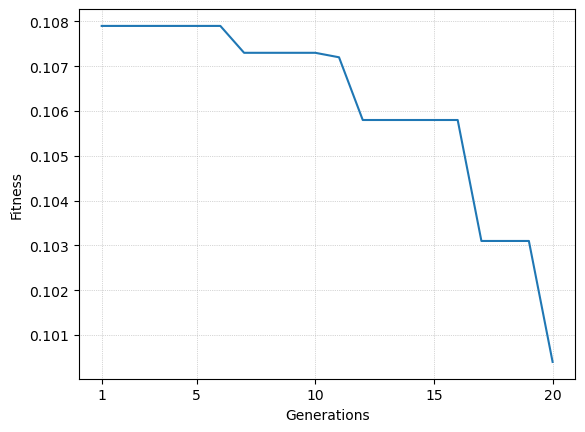

In [7]:
fitness = gpsr.get_train_fit_history()
generations = gpsr.generations
plt.plot(np.arange(1, generations+1), fitness)
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.xticks([1, 5, 10, 15, 20])
plt.grid(True, linestyle=":", linewidth=0.5)
plt.show()

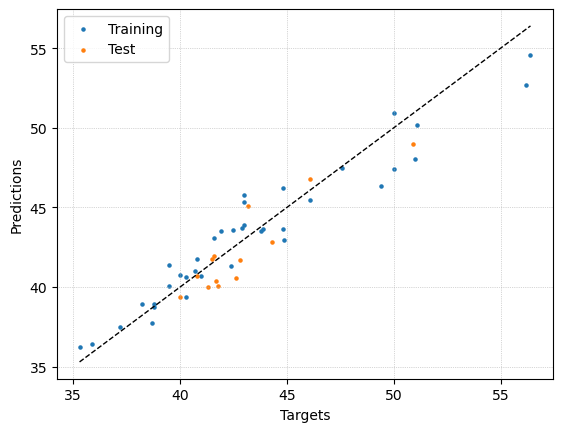

In [8]:
y_min = min(np.min(y_train_scaled), np.min(y_test))
y_max = max(np.max(y_train_scaled), np.max(y_test))

plt.scatter(y_train_scaled, pred_train, s=5, label="Training")
plt.scatter(y_test, u_best, s=5, label="Test")
plt.plot([y_min, y_max], [y_min, y_max], "k--", linewidth=1)
plt.grid(True, linestyle=":", linewidth=0.5)
plt.xlabel("Targets")
plt.ylabel("Predictions")
plt.legend()
plt.show()